In [1]:
import csv
import re
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa
import scipy #noqa

from matplotlib.colors import LogNorm, Normalize

import ipywidgets as w


In [2]:
DATASET_ROOT = Path("dataset")
DATASET = Path("dataset") / "2025-03-31-experiments.csv"

In [44]:
classification_records = []
analysis_records = []

#
HEADER_KEYS = ["platform", "nbInitiators", "nbTargets"]
ANALYSIS_KEYS = ["analysisTime", "semanticsSize", "graphReduction", "semanticsReduction"]
CLASSIFICATION_PPRINT = {"itf": "ITF", "red": "Redundant", "free": "Free"}

#
with DATASET.open() as dataset_file:
    for entry in csv.DictReader(dataset_file):
        # Cleanup csv keys
        entry = {k.strip(): v for k, v in entry.items()}
        # Ignore analysis failure
        if any(entry[k].strip() == "none" for k in ANALYSIS_KEYS):
            continue
        # Collect tags based on platform name
        TAGS = {
            "cluster_count": -1,
            "partition_count": -1,
            "cores_per_bank": -1,
        }
        tags = entry["platform"].split("_")
        for t in tags:
            # FIXME Those should be regular expressions to match the whole tag
            if t.endswith("Cl"):
                TAGS["cluster_count"] = int(t.replace("Cl", ""))
            if t.endswith("Prt"):
                TAGS["partition_count"] = int(t.replace("Prt", ""))
            if t.endswith("CorePerBank"):
                TAGS["cores_per_bank"] = int(t.replace("CorePerBank", ""))
        # Define shared header record fields
        record_header = {
            **{k: entry[k] for k in HEADER_KEYS},
            **TAGS,
            **{k + "_i": int(entry[k]) for k in HEADER_KEYS if k not in ["platform"]},
        }
        # Collect analysis statistics
        analysis_records.append({
            **record_header,
            **{k: float(entry[k]) for k in ANALYSIS_KEYS},
        })
        # Collect statistics per arity
        arity_max = int(max(k.rsplit(" ", 1)[1] for k in entry if "sem size" in k))
        for i in range(2, arity_max + 1):
            for c, classification in CLASSIFICATION_PPRINT.items():
                # Ignore if no transaction at arity
                sem_size = entry.get(f"sem size {i}", "none").strip()
                if sem_size == "none" or int(sem_size) <= 0:
                    continue
                # Cleanup count
                count = entry.get(f"{c} size {i}", "0").strip()
                if count == "none":
                    count = 0
                # Record classification
                classification_records.append({
                    **record_header,
                    "classification": classification,
                    "arity": str(i),
                    "arity_i": i,
                    "count": int(count),
                })

classification_df = pd.DataFrame.from_records(classification_records)
analysis_df = pd.DataFrame.from_records(analysis_records)

In [4]:
classification_counts = classification_df.groupby(
    by=["platform", "arity", "classification"]
)["count"].max().sort_index(ascending=False)

classification_counts.hvplot(
    kind="barh",
    by='classification',
    groupby='platform',
    x='arity',
    y='count',
    legend='bottom_right',
    widget_location='bottom',
    stacked=True,
    color=["#246EB9", "#FF9000", "#97CC04", ],
)

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Select(name='platform', options=[np.str_('GenericSample_8C...], value=np.str_('GenericSample_8Co...)

In [5]:
analysis_df.hvplot(
    by=['nbInitiators'],
    kind='points',
    logx=True,
    logy=True,
    x='semanticsSize',
    y='analysisTime',
    legend='bottom_right',
    widget_location='bottom',
)


HoloViews(NdOverlay, height=300, sizing_mode='fixed', widget_location='bottom', width=700)

In [6]:
analysis_df.hvplot(
    by=['nbInitiators'],
    kind='scatter',
    logx=True,
    logy=True,
    x='semanticsSize',
    y=['semanticsReduction'],
    legend='bottom_right',
    widget_location='bottom',
)


HoloViews(NdOverlay, height=300, sizing_mode='fixed', widget_location='bottom', width=700)

<Axes: xlabel='nbTargets_i', ylabel='nbInitiators_i'>

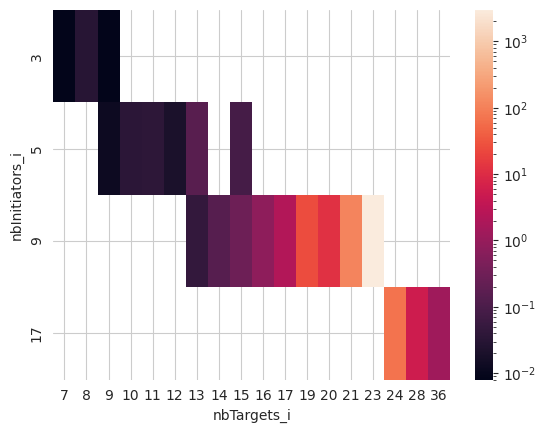

In [7]:
sns.heatmap(
    data=analysis_df.pivot_table(
        index="nbInitiators_i",
        columns="nbTargets_i",
        values="analysisTime",
        aggfunc="max",
    ),
    norm=LogNorm(),
)

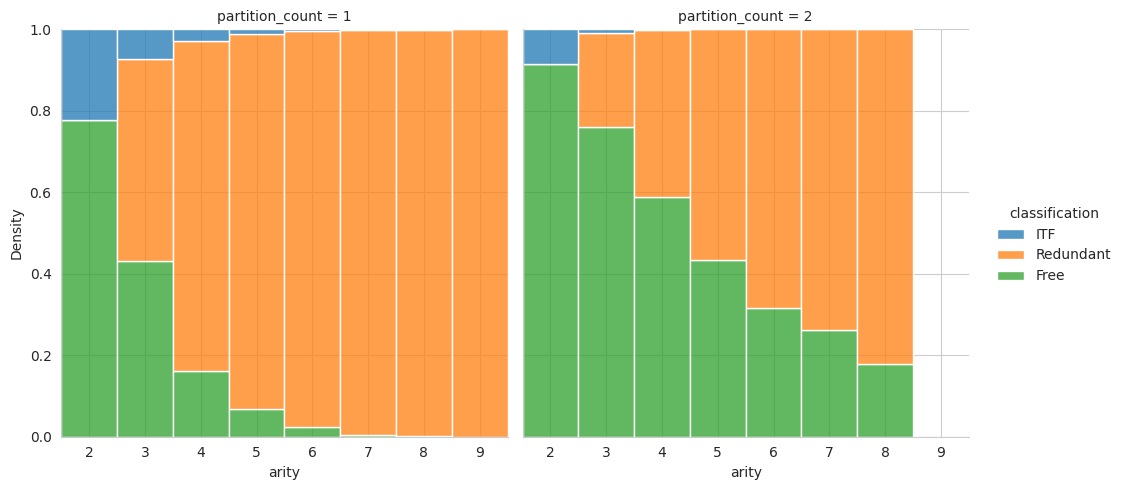

In [65]:
sns.displot(
    data=classification_df[classification_df["nbInitiators_i"] >= 5],
    kind="hist",
    x="arity",
    weights="count",
    hue="classification",
    multiple="fill",
    stat="density",
    col="partition_count",
    # row="nbInitiators_i",
)

In [66]:
hve = analysis_df.hvplot.explorer()
hve

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced08241', opts=None), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes08235', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=[], code="df.hvplot(\n    kind='scatter',\n    x='index',\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping08236', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic08238', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='scatter', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels08237', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer08213', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations08239', rasterize=False, x_sampling=None, y_sampling=None), statusbar=StatusBar(live_update=True, name='StatusBar08228'), style=Style(alpha=1, explorer=..., name='Style08240'), x='index', y='platform', y_multi=[], z=None)

In [67]:
cve = classification_df.hvplot.explorer()
cve

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced09906', opts=None), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes09900', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=[], code="df.hvplot(\n    kind='scatter',\n    x='index',\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping09901', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic09903', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='scatter', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels09902', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer09878', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations09904', rasterize=False, x_sampling=None, y_sampling=None), statusbar=StatusBar(live_update=True, name='StatusBar09893'), style=Style(alpha=1, explorer=..., name='Style09905'), x='index', y='platform', y_multi=[], z=None)